<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 10
## <center> Часть 4. Оценка важности признаков с Xgboost

## <center> Прогнозирование задержек вылетов

Ваша задача – побить как минимум 2 бенчмарка в [соревновании](https://www.kaggle.com/c/flight-delays-2017) на Kaggle Inclass. Подробных инструкций не будет, будет только тезисно описано, как получен второй – с помощью Xgboost. Надеюсь, на данном этапе курса вам достаточно бросить полтора взгляда на данные, чтоб понять, что это тот тип задачи, в которой затащит градиентный бустинг. Скорее всего Xgboost, но тут у нас еще немало категориальных признаков...

<img src='../../img/xgboost_meme.jpg' width=40% />

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [2]:
from sklearn.model_selection import cross_val_score

In [66]:
train = pd.read_csv('../../data/flight_delays_train.csv')
test = pd.read_csv('../../data/flight_delays_test.csv')

In [4]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
Month                100000 non-null object
DayofMonth           100000 non-null object
DayOfWeek            100000 non-null object
DepTime              100000 non-null int64
UniqueCarrier        100000 non-null object
Origin               100000 non-null object
Dest                 100000 non-null object
Distance             100000 non-null int64
dep_delayed_15min    100000 non-null object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [6]:
train.dtypes

Month                object
DayofMonth           object
DayOfWeek            object
DepTime               int64
UniqueCarrier        object
Origin               object
Dest                 object
Distance              int64
dep_delayed_15min    object
dtype: object

Итак, надо по времени вылета самолета, коду авиакомпании-перевозчика, месту вылета и прилета и расстоянию между аэропортами вылета и прилета предсказать задержку вылета более 15 минут. В качестве простейшего бенчмарка возьмем логистическую регрессию и два признака, которые проще всего взять: `DepTime` и `Distance`. У такой модели результат – 0.68202 на LB. 

In [7]:
X_train, y_train = train[['Distance', 'DepTime']].values, train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)

scaler = StandardScaler()
X_train_part = scaler.fit_transform(X_train_part)
X_valid = scaler.transform(X_valid)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [8]:
logit = LogisticRegression()

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.67956914653526068

In [9]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit.fit(X_train_scaled, y_train)
logit_test_pred = logit.predict_proba(X_test_scaled)[:, 1]

pd.Series(logit_test_pred, name='dep_delayed_15min').to_csv('data/logit_2feat.csv', index_label='id', header=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Второй бенчмарк, представленный в рейтинге соревнования, был получен так:
- Признаки `Distance` и  `DepTime` брались без изменений
- Создан признак "маршрут" из исходных `Origin` и `Dest`
- К признакам `Month`, `DayofMonth`, `DayOfWeek`, `UniqueCarrier` и "маршрут" применено OHE-преобразование (`LabelBinarizer`)
- Выделена отложенная выборка
- Обучалась логистическая регрессия и градиентный бустинг (xgboost), гиперпараметры бустинга настраивались на кросс-валидации, сначала те, что отвечают за сложность модели, затем число деревьев фиксировалось равным 500 и настраивался шаг градиентного спуска
- С помощью `cross_val_predict` делались прогнозы обеих моделей на кросс-валидации (именно предсказанные вероятности), настраивалась линейная смесь ответов логистической регрессии и градиентного бустинга вида $w_1 * p_{logit} + (1 - w_1) * p_{xgb}$, где $p_{logit}$ – предсказанные логистической регрессией вероятности класса 1, $p_{xgb}$ – аналогично. Вес $w_1$ подбирался вручную. 
- В качестве ответа для тестовой выборки бралась аналогичная комбинация ответов двух моделей, но уже обученных на всей обучающей выборке.

Описанный план ни к чему не обязывает – это просто то, как решение получил автор задания. Возможно, вы не захотите следовать намеченному плану, а добавите, скажем, пару хороших признаков и обучите лес из тысячи деревьев.

Удачи!

# <center>Оценка важности признаков с Xgboost
### <center>Работаем со стандартным интерфейсом

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale = 1.5)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb

In [2]:
from sklearn.metrics import roc_auc_score

In [3]:
train = pd.read_csv('../../data/flight_delays_train.csv')
test = pd.read_csv('../../data/flight_delays_test.csv')

In [4]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


Перекодируем данные для использования в xgboost

In [5]:
def feater_encoder(train, test):
    '''
    Возвращает перекодированные: train (без целевого признака), test и целевой признак y_train
    '''
    
    lab_enc = LabelEncoder()
    
    data = pd.concat([train.copy().drop('dep_delayed_15min', axis=1), test.copy()])
    
    data['Route'] = data['Origin'] + '-->' + data['Dest']
    data['Month'] = lab_enc.fit_transform(data['Month'])
    data['DayofMonth'] = lab_enc.fit_transform(data['DayofMonth'])
    data['DayOfWeek'] = lab_enc.fit_transform(data['DayOfWeek'])
    data['UniqueCarrier'] = lab_enc.fit_transform(data['UniqueCarrier'])
    data['Origin'] = lab_enc.fit_transform(data['Origin'])
    data['Dest'] = lab_enc.fit_transform(data['Dest'])
    data['Route'] = lab_enc.fit_transform(data['Route'])
    #data['DepTime'] = data['DepTime'] // 100    # результат не улучшают
    y_train = train['dep_delayed_15min'].map({'Y':1, 'N':0})
    
    return data[:train.shape[0]], data[train.shape[0]:], y_train

In [6]:
X_train, X_test, y_train = feater_encoder(train, test)

In [7]:
X_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Route
0,10,13,6,1934,1,19,82,732,171
1,6,12,2,1548,19,226,180,834,3986
2,11,11,4,1422,21,239,62,416,4091
3,2,17,5,1015,16,81,184,872,1304
4,1,28,5,1828,20,182,210,423,2979


Разделим данные на обучающую и отложенную выборку в соотношение 7:3. Инициализируем соответствующие объекты DMatrix dtrain и dtest.

In [9]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train,
                                                    test_size=0.3, stratify=y_train, random_state=17)
dtrain = xgb.DMatrix(X_train_part, y_train_part)
dvalid = xgb.DMatrix(X_valid, y_valid)

### Обучение модели

**Обучим всего 50 деревьев решений глубины 3.**

In [14]:
params = {
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'max_depth':3,
    'silent':1,
    'eta':0.5
}

num_rounds = 170

In [15]:
watchlist  = [(dvalid,'valid'), (dtrain,'train')] # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	valid-auc:0.691823	train-auc:0.683212
[1]	valid-auc:0.698806	train-auc:0.68987
[2]	valid-auc:0.701627	train-auc:0.692678
[3]	valid-auc:0.703601	train-auc:0.694936
[4]	valid-auc:0.70485	train-auc:0.695982
[5]	valid-auc:0.707411	train-auc:0.698974
[6]	valid-auc:0.710634	train-auc:0.701189
[7]	valid-auc:0.711368	train-auc:0.702256
[8]	valid-auc:0.714092	train-auc:0.705936
[9]	valid-auc:0.715956	train-auc:0.708154
[10]	valid-auc:0.717125	train-auc:0.709959
[11]	valid-auc:0.720537	train-auc:0.713267
[12]	valid-auc:0.721253	train-auc:0.714274
[13]	valid-auc:0.723677	train-auc:0.71621
[14]	valid-auc:0.724892	train-auc:0.717283
[15]	valid-auc:0.724798	train-auc:0.718081
[16]	valid-auc:0.726006	train-auc:0.719756
[17]	valid-auc:0.726264	train-auc:0.720553
[18]	valid-auc:0.726224	train-auc:0.721233
[19]	valid-auc:0.726519	train-auc:0.72211
[20]	valid-auc:0.727595	train-auc:0.723435
[21]	valid-auc:0.728027	train-auc:0.72376
[22]	valid-auc:0.728245	train-auc:0.724561
[23]	valid-auc:0.728355	tr

### Важность признаков

**F score (имхо - от "feature") при оценке важности признаков в Xgboost (не путать с F1 score как метрики качества классификации) вычисляется на основе того, как часто разбиение делалось по данному признаку.**

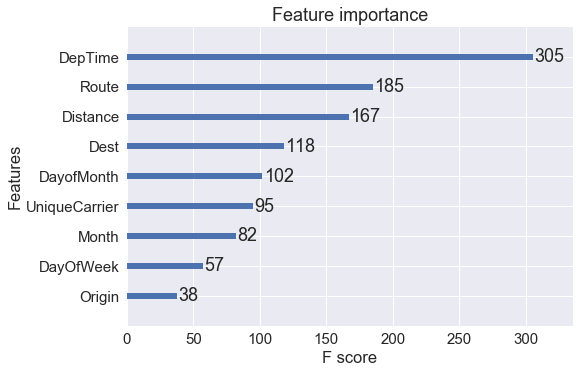

In [17]:
xgb.plot_importance(xgb_model);

**в виде словаря или DataFrame:**

In [18]:
importances = xgb_model.get_fscore()
importances

{'DayOfWeek': 57,
 'DayofMonth': 102,
 'DepTime': 305,
 'Dest': 118,
 'Distance': 167,
 'Month': 82,
 'Origin': 38,
 'Route': 185,
 'UniqueCarrier': 95}

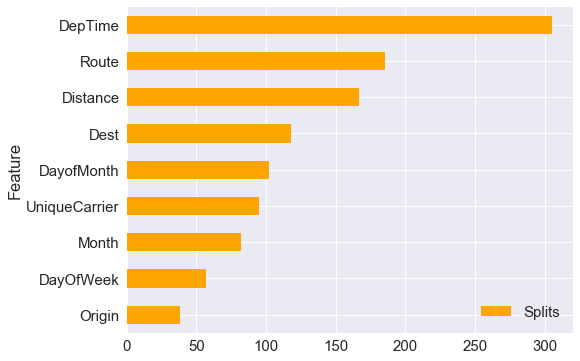

In [19]:
# create df
importance_df = pd.DataFrame({
        'Splits': list(importances.values()),
        'Feature': list(importances.keys())
    })
importance_df.sort_values(by='Splits', inplace=True)
importance_df.plot(kind='barh', x='Feature', figsize=(8,6), color='orange');